In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
#Configure Defaults
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
from tqdm import tqdm_notebook

plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

Spherical k-means for document clustering
- https://lovit.github.io/nlp/machine%20learning/2018/10/16/spherical_kmeans/

In [2]:
def summary(df) :
    pd.set_option('display.max_rows', 100)
    tf = pd.DataFrame({'데이터형태(dtypes)' : df.dtypes, 
                        '비 결측치 수(notnull' : df.notnull().sum(),
                        '결측치 수(null)' : df.isnull().sum(), 
                        '고유값 수(nunique)' : df.nunique()})
    return tf

In [39]:
df = pd.read_pickle('../data/result.pkl')
# 제목이 같은 항목 삭제 및 마지막 레코드만 남김
df = df.drop_duplicates(subset=['일자','언론사', '본문'], keep="last")
df = df.dropna(subset=['특성추출(가중치순 상위 50개)'], axis=0)
df['일자'].max(); df['일자'].min()
df.head()
df.shape

Timestamp('2022-02-28 00:00:00')

Timestamp('2017-01-01 00:00:00')

,일자,언론사,통합 분류1,통합 분류2,통합 분류3,키워드,특성추출(가중치순 상위 50개),본문
8674,2020-03-20,중도일보,경제>자원,경제>유통,지역>경남,"순수,국산,수매,밀가루,시범,판매,농산물,면역,증진,효과,노화,억제,한국농수산식품유...","시범판매,밀가루,농산물,밀산업,자급률,병해충,소비자,육성법,소비량,신규제품,16톤,...","한국농수산식품유통공사(aT, 사장 이병호)는 지난해 수매한 국산 밀가루 16톤을 오..."
8675,2020-03-20,중도일보,지역>전북,지역>전남,지역>강원,"물고기,채소농사,고창군,아쿠아포닉스,채소,전국,출하,아쿠아포닉스,농법,착공,시설,출...","아쿠아포닉스,고창군,고창군청,지원사업,이영성,아쿠아포닉스코리아,재배법,수경재배,환경...",전북 고창군의 한 농장이 물고기 양식장에서 나온 유기물로 작물을 재배하는 '아쿠아포...
8678,2020-03-20,전북도민일보,지역>충북,지역>대전,지역>전북,"남부안농협,토양,개량제,무상,지원,남부안농협,조합장,최우식,로컬,푸드,농산물,생산,...","남부안농협,로컬푸드,토양개량제,직매장,농산물,고품질,무상지원,농가소득,732포,최우...",남부안농협(조합장 최우식)은 로컬푸드 고품질 농산물 생산을 위한 토양개량 지원사업...
8687,2020-03-20,충청투데이,경제>유통,경제>자원,NaN,"취나물,부여,백마강,부여군농업기술센터,남면,지역,백마강,취나물,출하,본격적,시작,1...","면역력,백마강,부여군,관계자,부여군농업기술센터,병해충,클로로젠산,농약허용물질목록관리...",[충청투데이 김일순 기자] 부여군농업기술센터는 남면 지역에서 고품질 백마강 취나물 ...
8689,2020-03-19,대전일보,지역>경기,지역>충남,경제>자원,"보령시,공모,타작물,생산,장비,지원,사업,보령,보령시,타작물,재배,확산,타작물,재배...","타작물,보령시,농업인,간척지,ha,연명부,소재지,기반정비,선별기,방제기,수확기,농기...",[보령] 보령시는 논 타작물 재배 확산을 위해 타작물 재배에 필요한 기반정비 및 생...


(570265, 8)

In [40]:
df[df['일자'] > '2020-02-20'].shape
df[df['일자'] <= '2020-02-20'].shape

df = df[df['일자'] <= '2020-02-20']
df.shape

(464686, 8)

(105579, 8)

(105579, 8)

## 불용어 

In [5]:
data1 = pd.read_excel('../data/출현단어_5만 _박태욱.xlsx')
data2 = pd.read_excel('../data/출현단어_10만_권성희.xlsx')
data3 = pd.read_excel('../data/출현단어_20만_권성희.xlsx')

data1.shape
data2.shape
data3.shape

data = data1.append(data2).append(data3)
data.shape

(50000, 4)

(50000, 4)

(50000, 4)

(150000, 4)

In [6]:
stop_words_01 = data[data['선택'] == 0]['출현단어'].tolist()
print('채택단어', len(data[data['선택'] == 1]))
print('불용어비율', len(data[data['선택'] == 0])/len(data)*100)
stop_words = list(set(stop_words_01))

채택단어 11465
불용어비율 92.35466666666666


In [7]:
for i in df.언론사.value_counts().index :
    stop_words.append(i)
    
for i in ['미국', '국내', '한국', '대표', '중국','일본', '가격', '글로벌', '기업', '대상', '정부', '세계', '국회', '관심', '방송'] :
    stop_words.append(i)

for i in ['인사', '발령', '공개모집', '필기시험', '발령', '인사 발령', '과장', '전보', '일자', '공무원', '국장', '점검', '실시'] :
    stop_words.append(i)
    
common = ["전략", "연구", "평가", "마련", "조사", "관리", "보다", "관련","전문가","예정","이번", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
          "총회", "대한", "통해", "한국","국내","개최","행사","우수","장관","피해","해외","일자리","박람회", "지원", "위해", "총회","국제","분야","세계",
          "식품과학","국립","시민","통합", "정책", "대해", '선정', '아시아경제']
for i in common :
    stop_words.append(i)

for i in ['두고', '농협', '시행', '식품안전', '안전', '참여', '이상', '조치', '개선', '관내', '참석', '대전', '확산', '조성', '홍보'] :
    stop_words.append(i)
    
for i in ['대한민국', '홈페이지', '상반기', '시간date', '이명박', '박근혜', '청와대', '위원회',
          '그동안', '1만', '회용', '사람들', '앤서니', '이재명', '더불어민주당', '민주당',
         '봉준호', '시상식', '만큼','위원장', '관계자', '서울', '국민의힘', '윤석열', 'a씨', '식품의약품안전처', '식약처','소비자들', '농림축산식품부',
         '식품부', '농식품부']:
    stop_words.append(i)

len(list(set(stop_words)))
stop_words = list(set(stop_words))

138564

# 1. 사이킷런 LDA
## 불용어를 Countvector()에서 적용

## 특성추출(가중치순 상위 50개)로 corpus 구성

In [81]:
corpus = []

for keywords in df['특성추출(가중치순 상위 50개)']:
    corpus.append(keywords)

corpus[:2]

['천안사,화상병,개화기,그동안,강성수,기술교육,농가실천사항,관리제도,검역병,정보교환,농가들,기술향상,병해충,천안시농업기술센터,pls,천안,천안시,농가,교육,발전,농약,향상,방제,확대,사과,생산,소장,개최,제도,관리,목록,물질',
 '재활용품,괴산읍,괴산새마을회,비닐포대,재활용,농약봉지,회원들,재사용,마을회,노명식,농약병,홍범식고택,괴산군,수익금,행사,자원,일원,수집,지역,판매,의미,이웃,봉지,농약,발생,비닐,회원,주변,회장,포대,수거,방치,이날,환경,사용']

### 불용어 적용

In [43]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
vect = CountVectorizer(stop_words = stop_words, ngram_range=(1, 2), min_df= 0.0015, max_df= 0.9)
X = vect.fit_transform(corpus) # Doc-Term Matrix 계산
len(vect.get_feature_names())
X

#from scipy import sparse
#X.toarray()
#sparse.csr_matrix(X.toarray())

192

<105579x192 sparse matrix of type '<class 'numpy.int64'>'
	with 131022 stored elements in Compressed Sparse Row format>

In [44]:
#pd.DataFrame(X.toarray(), columns = vect.get_feature_names())

In [45]:
from sklearn.decomposition import LatentDirichletAllocation
# 5개의 주제만 뽑았으니 n_components(토픽개수) 5로 설정
lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(X)
# components_속성은 8개의 토픽별(row)로 1000개의 feature(단어)들의 분포수치(column)를 보여줌
print(lda.components_.shape)
print(lda.components_)

LatentDirichletAllocation(n_components=4, random_state=42)

(4, 192)
[[7.50766062e-01 2.93628351e-01 2.60032246e-01 4.38396581e+01
  1.66227960e+02 4.36882383e+02 2.54130701e-01 1.21327191e+01
  2.54033705e-01 2.51603699e-01 8.02534339e-01 2.56463429e-01
  2.53168473e-01 2.55713228e-01 3.80103281e+01 2.80820122e+02
  2.52770389e-01 4.12075765e+01 2.84321139e-01 2.53426050e-01
  2.52087170e-01 2.52500017e-01 2.52463100e-01 2.52922753e-01
  2.52630873e-01 2.53704975e-01 2.51528065e-01 2.51664896e-01
  2.54450359e-01 2.51903193e-01 5.45778073e-01 2.52500133e-01
  2.52755676e-01 2.50658126e-01 2.51125337e-01 2.51548985e-01
  2.51006506e-01 2.50905278e-01 2.50641877e-01 2.52063527e-01
  2.52401922e-01 2.55811219e-01 3.59631242e-01 2.50989214e-01
  2.54351214e-01 4.18798028e+01 1.03232289e+00 2.58417710e-01
  2.54577802e-01 2.53447290e-01 2.52424684e-01 2.52449107e-01
  2.52004673e-01 2.51986771e-01 2.51319573e-01 2.52104176e-01
  2.51299002e-01 2.53871566e-01 2.38597038e+01 2.84883990e+01
  2.58605826e-01 2.51826403e-01 2.53176999e-01 2.52056767e-01

In [46]:
# 이 때 lda_model이란, 벡터화시킨 텍스트 데이터를 fit까지만 적용한 모델!
def display_topic_words(lda_model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(lda_model.components_):
        print('\nTopic #', topic_idx+1)
        
        # Topic별로 1000개의 단어들(features)중에서 높은 값 순으로 정렬 후 index를 반환해줌!
        # argsort()는 디폴트가 오름차순임(1,2,3,...) 그래서 [::-1]로 내림차순으로 바꿔주기
        topic_word_idx = topic.argsort()[::-1]
        top_idx = topic_word_idx[:num_top_words]
        
        # CountVectorizer함수 할당시킨 객체에 get_feature_names()로 벡터화시킨 feature(단어들)볼 수 있음!
        # 이 벡터화시킨 단어들(features)은 숫자-알파벳순으로 정렬되며, 단어들 순서는 fit_transform시키고 난 이후에도 동일!
        # '문자열'.join 함수로 특정 문자열 사이에 끼고 문자열 합쳐줄 수 있음.
        feature_concat = '+'.join([str(feature_names[i])+'*'+str(round(topic[i], 1)) for i in top_idx])
        print(feature_concat)    
        
feature_names = vect.get_feature_names()
display_topic_words(lda, feature_names, 15)


Topic # 1
의약품*6159.5+중금속*5113.0+안전성*2331.6+첨가물*2308.3+제품*2290.8+소비자*2139.4+오염수*1554.2+식품*1486.1+유해물질*1085.6+화학물질*876.2+수산물*759.5+제약사*656.2+환경호르몬*579.2+원재료*536.2+유통기한*523.7

Topic # 2
소비자*5512.1+발암물질*3405.2+곰팡이*3040.2+농산물*2922.6+화합물*1186.2+친환경*1094.2+농업인*1031.2+이물질*726.2+유해물질*615.9+bpa*607.7+맥도날드*553.2+농약*533.1+생산자*505.5+잔류농약*460.8+gmo*430.1

Topic # 3
대장균*2504.6+건강기능식품*1599.0+소비자*1507.1+식중독*1404.3+미생물*1378.0+음식물*1161.2+유산균*976.4+생수*920.2+냉장고*823.2+음식점*781.9+오염물질*607.2+프로바이오틱스*602.8+소고기*590.1+포도상구균*580.2+불량식품*535.5

Topic # 4
온라인*3361.1+단백질*2079.9+건강*1974.3+면역력*1659.2+건강기능식품*1589.9+축산물*1555.2+추출물*1454.2+영양소*1330.8+소비자*1227.4+호르몬*916.2+건강관리*897.2+수산물*790.0+항산화*737.2+지하수*685.9+돼지고기*671.2


In [47]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] 
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_top_words(lda, vect.get_feature_names(), 20)

Topic #0: 의약품, 중금속, 안전성, 첨가물, 제품, 소비자, 오염수, 식품, 유해물질, 화학물질, 수산물, 제약사, 환경호르몬, 원재료, 유통기한, 가공식품, 커피, 위생법, 식품첨가물, 짜파구리
Topic #1: 소비자, 발암물질, 곰팡이, 농산물, 화합물, 친환경, 농업인, 이물질, 유해물질, bpa, 맥도날드, 농약, 생산자, 잔류농약, gmo, 미생물, 농작물, 패티, 농식품, 패스트푸드점
Topic #2: 대장균, 건강기능식품, 소비자, 식중독, 미생물, 음식물, 유산균, 생수, 냉장고, 음식점, 오염물질, 프로바이오틱스, 소고기, 포도상구균, 불량식품, 식감, 수질검사, 음식, 아이스크림, 식재료
Topic #3: 온라인, 단백질, 건강, 면역력, 건강기능식품, 축산물, 추출물, 영양소, 소비자, 호르몬, 건강관리, 수산물, 항산화, 지하수, 돼지고기, 건강식품, 섭취량, 식재료, 원산지, 지방산


In [48]:
# transform까지 수행하면, 문서별(row)로 토픽들(column)의 분포를 알려줌
doc_topics = lda.transform(X)
print(doc_topics.shape)
print(doc_topics[:2])

(105579, 4)
[[0.08333352 0.74999387 0.08333355 0.08333906]
 [0.12500023 0.62498531 0.12500027 0.12501419]]


In [49]:
trend_data = pd.DataFrame(doc_topics, columns= ['Topic #1', 'Topic #2', 'Topic #3', 'Topic #4'])
trend_data['start'] = df['일자'].values
trend_data = trend_data.set_index('start')
trend_data = trend_data.resample('M').mean()
trend_data#.background_gradient(cmap='Blues')

,Topic #1,Topic #2,Topic #3,Topic #4
start,,,,
2017-01-31,0.288418,0.238631,0.241675,0.231277
2017-02-28,0.260264,0.266229,0.248047,0.225460
2017-03-31,0.235816,0.280866,0.258988,0.224330
2017-04-30,0.281424,0.266181,0.229730,0.222665
2017-05-31,0.279639,0.244838,0.263512,0.212011
2017-06-30,0.289777,0.231992,0.259247,0.218985
2017-07-31,0.257190,0.266752,0.274236,0.201821
2017-08-31,0.276544,0.292478,0.238938,0.192040
2017-09-30,0.271128,0.262747,0.237352,0.228774


Text(0.5, 1.0, 'Topic #1')

Text(0.5, 1.0, 'Topic #2')

Text(0.5, 1.0, 'Topic #3')

Text(0.5, 1.0, 'Topic #4')

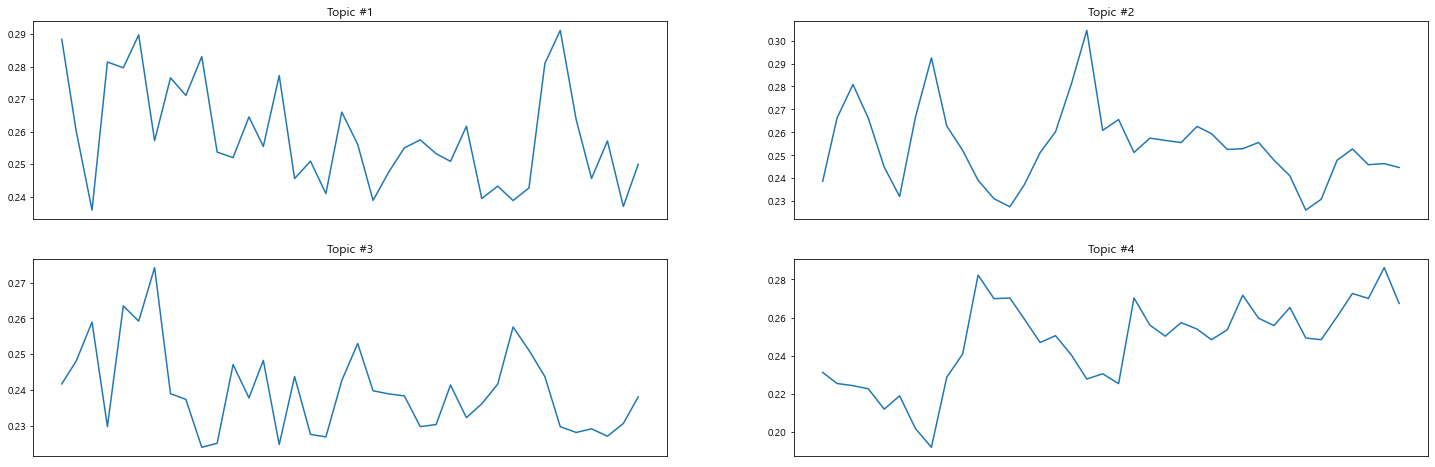

In [63]:
fig, axes = plt.subplots(2, 2, sharex='col', figsize=(25, 8)) 
for col, ax in zip(trend_data.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend_data[col])
plt.show()

<Figure size 1440x360 with 0 Axes>

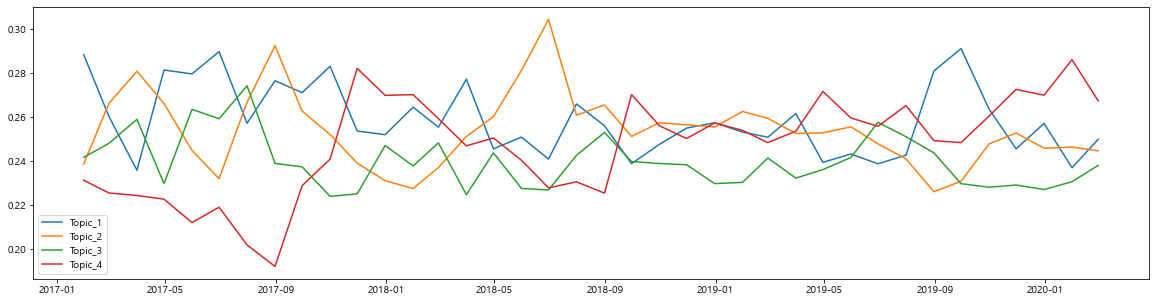

In [73]:
plt.figure(figsize=(20, 5))
plt.plot(trend_data)
plt.legend(labels=('Topic_1', 'Topic_2', 'Topic_3', 'Topic_4'), loc='best')

In [51]:
#X = TfidfTransformer().fit_transform(X)

count = X.toarray().sum(axis=0) # Doc-Term Matrix 각 단어에 대한 합

#count = np.random.permutation(X.toarray()).sum(axis=0) 행으로 permutation하여도 상관없음
idx = np.argsort(-count)
count = count[idx]

feature_name = np.array(vect.get_feature_names())[idx]
len(feature_name)
keyword_list = list(zip(feature_name, count))
result_df = pd.DataFrame(keyword_list)
result_df.head(20)

192

,0,1
0,소비자,10385
1,의약품,6171
2,중금속,5119
3,발암물질,3405
4,온라인,3361
5,건강기능식품,3189
6,곰팡이,3040
7,농산물,2923
8,대장균,2564
9,첨가물,2441


In [52]:
len(vect.get_feature_names())
vect.get_feature_names()[:10]

192

['bpa', 'cj제일제당', 'epa', 'gmo', 'haccp', '가공식품', '간편식', '건강', '건강 식품', '건강관리']

### Topic에 속한 기사의 단어가 코사인 유사성을 구한다

In [137]:
from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{2,}") # 정규포현식으로 토크나이저를 정의
food_stops = set(stop_words) # 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text) 
    # stopwords 제외
    words = [word for word in tokens if (word not in food_stops) and len(word) >= 2] # 2글자 이상만
    return words

data = pd.DataFrame(doc_topics, columns= ['Topic #1', 'Topic #2', 'Topic #3', 'Topic #4'])

data['topic'] = np.argmax(doc_topics, axis=1)
data
data['topic'].value_counts()

df.index =np.arange(len(df))
data = df.loc[data[data['topic'] == 0].index, :]

corpus = [tokenizer(news) for news in data['특성추출(가중치순 상위 50개)']]

,Topic #1,Topic #2,Topic #3,Topic #4,topic
0,0.08,0.75,0.08,0.08,1
1,0.13,0.62,0.13,0.13,1
2,0.06,0.81,0.06,0.06,1
3,0.25,0.25,0.25,0.25,0
4,0.05,0.85,0.05,0.05,1
...,...,...,...,...,...
105574,0.45,0.07,0.41,0.06,0
105575,0.81,0.06,0.06,0.07,0
105576,0.25,0.25,0.25,0.25,0
105577,0.25,0.25,0.25,0.25,0


0    62727
1    15944
3    14958
2    11950
Name: topic, dtype: int64

In [138]:
corpus[:2]

[['노명식', '농약봉지', '농약병', '비닐포대', '홍범식고택'],
 ['불법경작지',
  '연평리',
  '경작금지',
  '내각리',
  '불법경작행위',
  '하천정원화',
  '남행정복지센터장',
  '남행정복지센터남양주시',
  '남행정복지센터']]

In [139]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=corpus, size=100, window=5, min_count=50, workers=4, sg=0)

word_vectors = model.wv
word_vectors
vocabs = word_vectors.vocab.keys()
vocabs
word_vectors_list = [word_vectors[v] for v in vocabs]
len(word_vectors_list)

dict_keys(['소비자', '의약품', '농산물', '안전성', '가공식품', '잔류농약', '의약외품', '제품', '식품', '온라인', '화학물질', 'haccp', '먹이사슬', '수입식품', '식중독', '유해물질', '수산물', '양식장', '해수부', '농수산물', '보존제', '음식점', '식수원', '식재료', '제약바이오', '유통기한', '천일염', '약사법', '무상급식', '제약사', '신약개발', '원재료', '제약업계', 'bpa', '해양수산부', '환경호르몬', '단맛', '일동제약', 'bse', '쇠고기', '원산지', '건강', '단백질', '의약국', 'gmo', '식품업', '식약청', '바이오의약품', '미생물', '건강기능식품', '롯데칠성음료', '식용유', '조미료', '식품위생법', '첨가물', '위생법', '세계무역기구', '일반의약품', '전문의약품', '자연주의', '면역력', '제약사들', '섭취', '건강식품', '벌집', '보령제약', '한미약품', '매일유업', '추출물', '중외제약', '원료의약품', '축산물', '이물질', '위생', '식도염', '사탕수수', '섭취량', '대웅제약', '영양소', '복제약', '주방용품', '식생활', '건강상태', '식약처장', '음료', '식중독균', '식품첨가물', '국민건강', '커피', '유해화학물질', '강수량', '곰팡이', '화합물', '의약품청', '발암성', '지하수', '술병', '중금속', '짜파구리', '짜파게티', '생수병', '냅킨', '절주', '대장균', '정수기', '구호품', '주스', '오염수', '혈압약', '오염물질', '발암물질', '위장약', '완제의약품', '고혈압약', '허용량', '허용치', '오염토', '호르몬제', '호르몬', 'wfp', '세계식량계획', '피임약', '합성첨가물', '코리티졸', '불량식품'])

125

### 유사도는 −1에서 1까지의 값을 가지며, −1은 서로 완전히 반대되는 경우, 0은 서로 독립적인 경우, 1은 서로 완전히 같은 경우를 의미한다.

In [140]:
from sklearn.metrics import pairwise_distances
pd.options.display.float_format = '{:,.2f}'.format
cosinematrix = pd.DataFrame(cosine_similarity(word_vectors_list,dense_output=False), columns=vocabs)
cosinematrix.index = vocabs

In [141]:
# 단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그린다
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

def plot_2d_graph(vocabs, xs, ys):    
    plt.figure(figsize=(10 ,10))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

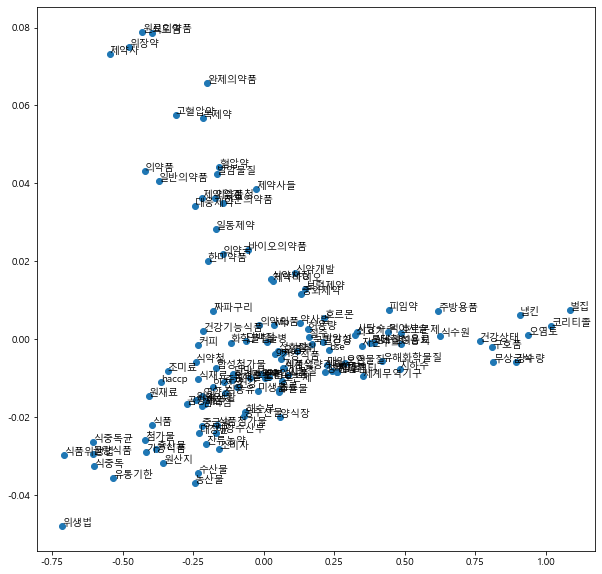

In [142]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]
 
# 결과2

plot_2d_graph(vocabs, xs, ys)

# 2. Gensim 패키지 
### perplex, coherence 적용 가능
### 불용어를 원래 자료에서 적용하여야 함
### https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [19]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

## 불용어 정리

In [54]:
from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{2,}") # 정규포현식으로 토크나이저를 정의
food_stops = set(stop_words) # 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text) 
    # stopwords 제외
    words = [word for word in tokens if (word not in food_stops) and len(word) >= 2] # 2글자 이상만
    return words

texts = [tokenizer(news) for news in df['특성추출(가중치순 상위 50개)']]

### 박상언교수
https://github.com/wikibook/textmining/blob/main/Ch%2007.%20%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [55]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
# Create Corpus: Term Document Frequency 
# corpus = [id2word.doc2bow(text) for text in data_words if text not in stop_words]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 171452
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 105579


In [56]:
from gensim.models import LdaModel

num_topics = 4
passes = 5
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics, \
                       random_state=7)

Wall time: 35.2 s


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 0')

[Text(0, 0, '소비자'),
 Text(1, 0, '불량식품'),
 Text(2, 0, '첨가물'),
 Text(3, 0, '의약품'),
 Text(4, 0, '온라인'),
 Text(5, 0, '식품'),
 Text(6, 0, '축산물'),
 Text(7, 0, '유통기한'),
 Text(8, 0, '농산물'),
 Text(9, 0, '원산지')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 1')

[Text(0, 0, '중금속'),
 Text(1, 0, '호르몬'),
 Text(2, 0, '제품'),
 Text(3, 0, '오염수'),
 Text(4, 0, '친환경'),
 Text(5, 0, '환경호르몬'),
 Text(6, 0, '음식점'),
 Text(7, 0, '유해물질'),
 Text(8, 0, '발암물질'),
 Text(9, 0, '음료')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 2')

[Text(0, 0, '단백질'),
 Text(1, 0, '의약품'),
 Text(2, 0, '면역력'),
 Text(3, 0, '건강'),
 Text(4, 0, '식습관'),
 Text(5, 0, '영양소'),
 Text(6, 0, '음식물'),
 Text(7, 0, '추출물'),
 Text(8, 0, '건강기능식품'),
 Text(9, 0, '여성호르몬')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 3')

[Text(0, 0, '식중독'),
 Text(1, 0, '미생물'),
 Text(2, 0, '화학물질'),
 Text(3, 0, '돼지고기'),
 Text(4, 0, '위생'),
 Text(5, 0, '이물질'),
 Text(6, 0, '곰팡이'),
 Text(7, 0, '제약사'),
 Text(8, 0, '패스트푸드점'),
 Text(9, 0, '식중독균')]

<BarContainer object of 0 artists>

<BarContainer object of 0 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 4')

[Text(-0.06, 0, ''),
 Text(-0.039999999999999994, 0, ''),
 Text(-0.019999999999999997, 0, ''),
 Text(0.0, 0, ''),
 Text(0.020000000000000004, 0, ''),
 Text(0.04000000000000001, 0, ''),
 Text(0.06, 0, '')]

<BarContainer object of 0 artists>

<BarContainer object of 0 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 5')

[Text(-0.06, 0, ''),
 Text(-0.039999999999999994, 0, ''),
 Text(-0.019999999999999997, 0, ''),
 Text(0.0, 0, ''),
 Text(0.020000000000000004, 0, ''),
 Text(0.04000000000000001, 0, ''),
 Text(0.06, 0, '')]

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

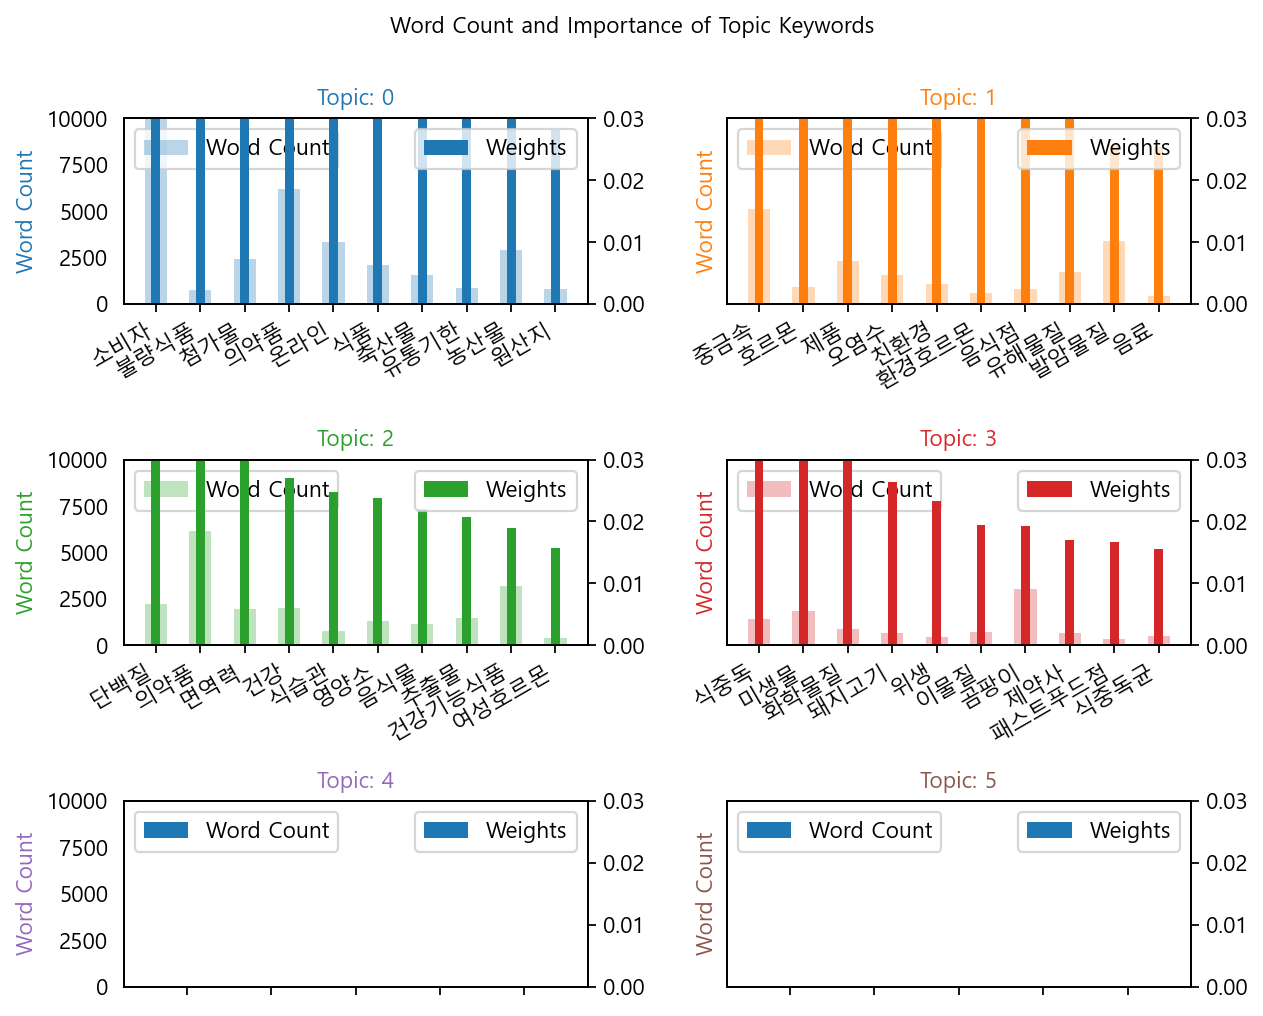

In [60]:
from collections import Counter
import matplotlib.colors as mcolors

topics = model.show_topics(formatted=False)
#topics = model.show_topics(num_words=10, formatted=False)

data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

sf = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=sf.loc[sf.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=sf.loc[sf.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 10000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(sf.loc[sf.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=10, y=1.05)    
plt.show()

In [ ]:
#df.to_excel('../data/코로나후.xlsx')

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

In [124]:
pyLDAvis.save_html(vis, '../data/002.html')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 혼란도와 토픽 응집도를 이용한 최적값 선택

In [125]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-8.870521538093708


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics: 3, perplexity: -6.615, coherence: -7.806
num_topics: 4, perplexity: -6.645, coherence: -9.377
num_topics: 5, perplexity: -6.663, coherence: -9.343
num_topics: 6, perplexity: -6.723, coherence: -10.155
num_topics: 7, perplexity: -6.728, coherence: -10.520
num_topics: 8, perplexity: -6.736, coherence: -10.309
num_topics: 9, perplexity: -6.826, coherence: -12.270
num_topics: 10, perplexity: -6.840, coherence: -12.302
num_topics: 11, perplexity: -6.879, coherence: -11.413
num_topics: 12, perplexity: -6.920, coherence: -12.187
num_topics: 13, perplexity: -7.401, coherence: -12.739
num_topics: 14, perplexity: -8.123, coherence: -12.494
num_topics: 15, perplexity: -9.571, coherence: -12.522


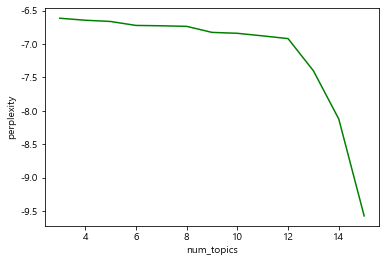

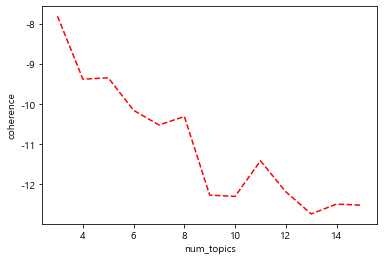

In [126]:
def show_coherence(corpus, dictionary, start=3, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=3, end=15)

### Dynamic Topic Modeling in Python
- https://radimrehurek.com/gensim/models/ldaseqmodel.html
-= https://markroxor.github.io/gensim/static/notebooks/ldaseqmodel.html#topic=0&lambda=1&term=

In [61]:
time_slice = df.set_index('일자').resample('3M')['특성추출(가중치순 상위 50개)'].count().tolist()
time_slice

[847,
 2723,
 3280,
 4478,
 5020,
 5271,
 8464,
 7489,
 7748,
 10060,
 12965,
 13683,
 15421,
 8130]

In [91]:
from gensim.test.utils import common_corpus
from gensim.models import LdaSeqModel

#ldaseq = LdaSeqModel(corpus=corpus, time_slice=time_slice, num_topics=4, chunksize=1)

# 문서간 Cosine similarity와 1 kernel density estimation을 이용한 군집 개수 정의
### word2vec cosine similarity

In [74]:
tfidf_matrix = TfidfTransformer().fit_transform(X)
tfidf_matrix.toarray().shape

(105579, 192)

In [75]:
pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names()).sample(frac=1, random_state=114)

,bpa,cj제일제당,epa,gmo,haccp,가공식품,간편식,건강,건강 식품,건강관리,...,해산물,해수부,해양수산부,해조류,햄버거병,호르몬,호박즙,화학물질,화합물,환경호르몬
34406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
tfidf_matrix.shape

(105579, 192)

In [77]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_matrix

MemoryError: Unable to allocate 83.1 GiB for an array with shape (105579, 105579) and data type float64

ValueError: too many values to unpack (expected 3)

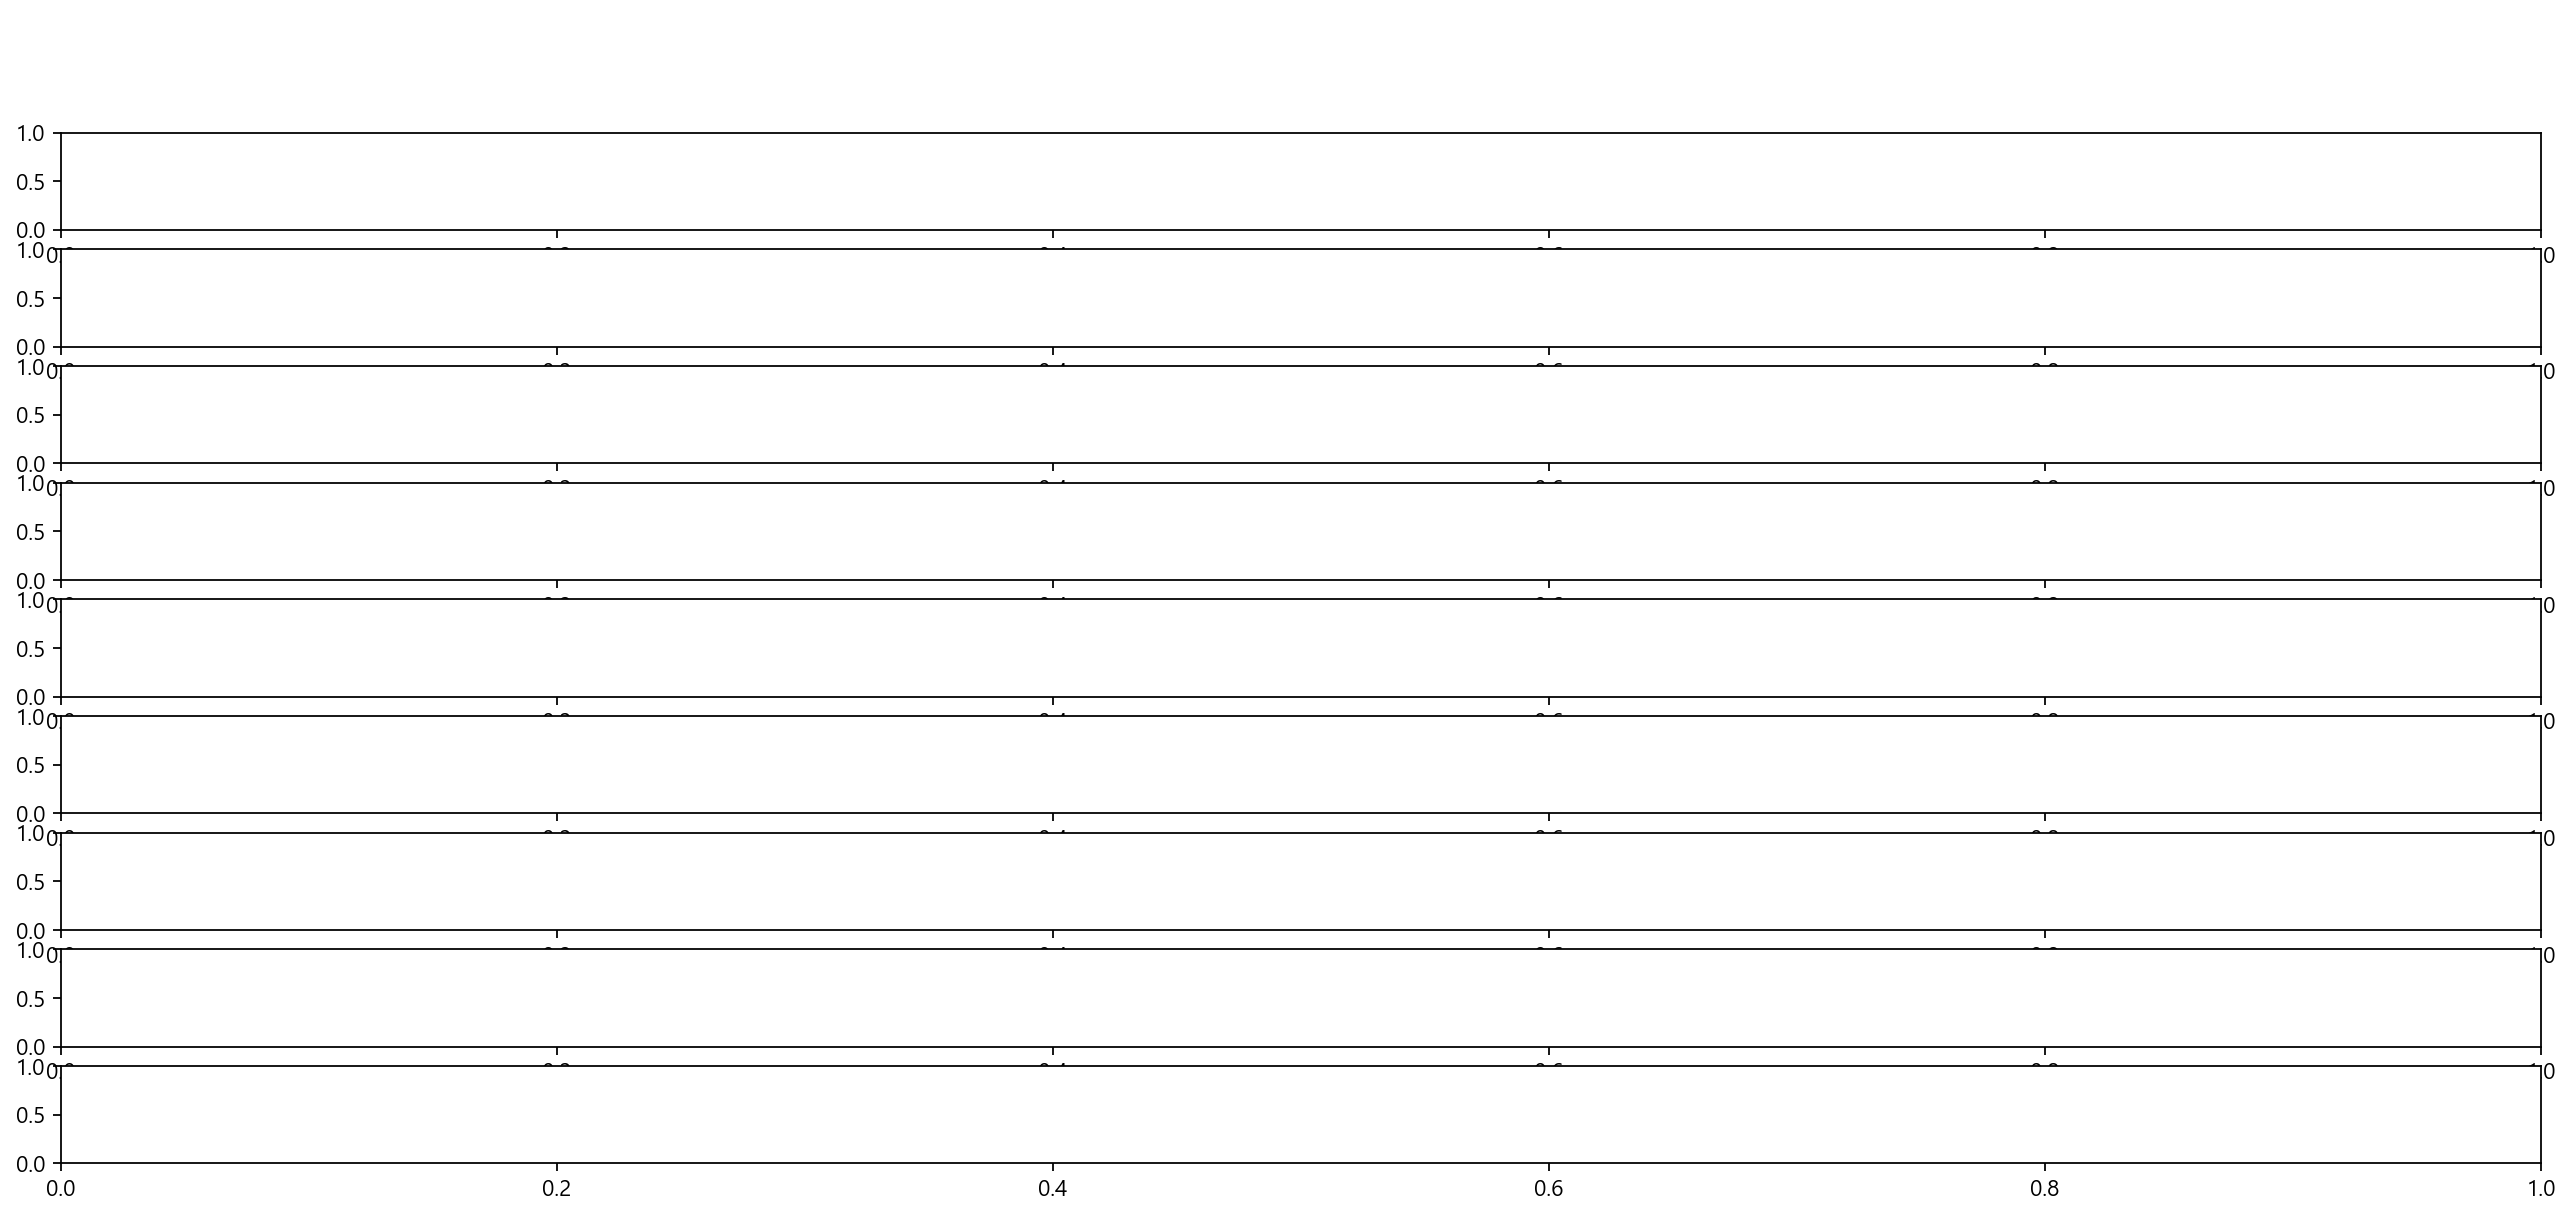

In [36]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=model, corpus=corpus, start = 0, end = 10):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=12, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=12, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=18, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [157]:
data_ready = data_words

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

KeyboardInterrupt: 

In [34]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,1.0,"그동안,별자리,웬수,부모님,게자리,찜질방,금전운,황소자리,일들,대인관계,동아리회식,...","[시범판매,밀가루,농산물,밀산업,자급률,병해충,소비자,육성법,소비량,신규제품,16톤..."


In [160]:
# Display setting to show more characters in column
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,2,1.0,"그동안,별자리,웬수,부모님,게자리,찜질방,금전운,황소자리,일들,대인관계,동아리회식,...","[시범판매,밀가루,농산물,밀산업,자급률,병해충,소비자,육성법,소비량,신규제품,16톤..."


<AxesSubplot:>

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 2')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 3')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

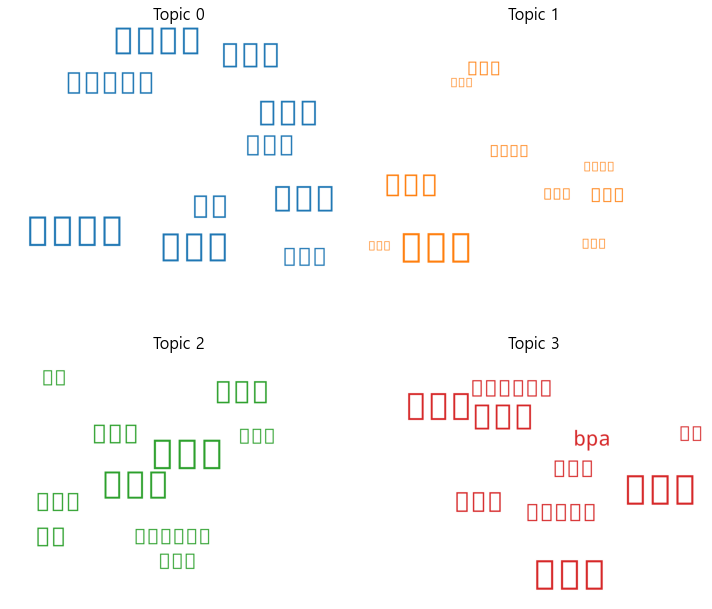

In [56]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

plt.rcParams['font.family']='Malgun Gothic'

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0
                 )

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()